# [GSE85217] UMAP

# Import libraries

In [7]:
!jupyter-lab enable widgetsnbextension

[C 2024-11-01 14:20:45.778 ServerApp] No such file or directory: /home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/code/local_version/nb/enable


In [93]:
# lib
#import modin.pandas as pd
import pandas as pd
import numpy as np
import os
from collections import OrderedDict
import umap

# fig
import matplotlib.pyplot as plt
import seaborn as sns

# local lib
import sys
sys.path.insert(1,'/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/code/local_version/fun')

from parser import Data

In [94]:
class DimReduction():
    
    def __init__(self,mat_embedded:pd.DataFrame=None,metadata:pd.DataFrame=None,palette:dict=None,clusters:list=None):
        self.mat_embedded=mat_embedded
        self.metadata=metadata
        self.palette=palette
        self.clusters=clusters
        
    def add_mat_embedded(self,mat_embedded:pd.DataFrame):
        
        if mat_embedded.shape[1]!=2:
            raise ValueError("Matrix embedded dimensions is not equal to 2 !")
        
        self.mat_embedded=mat_embedded
    
    def add_metadata(self,metadata):
        self.metadata=metadata
    
    def add_palette(self,palette):
        self.palette=palette
    
    def add_clusters(self,col_clusters:str,metadata:pd.DataFrame=None):
        
        if metadata is None:
            metadata=self.metadata
            
        if col_clusters in metadata.columns:
            self.clusters=metadata[col_clusters]
        else:
            raise ValueError(f"{col_clusters} is not in metadata columns names")
    
    @staticmethod
    def check_index(mat1:pd.DataFrame,mat2:pd.DataFrame) -> pd.DataFrame:
        
        index_mat1=mat1.index.to_list()
        index_mat2=mat2.index.to_list()
        
        if len(set(index_mat2).difference(set(index_mat1)))!=0:
            raise ValueError("The index do not match!")
        
        mat1=mat1.loc[index_mat2,]
        
        return mat1
        
    def compute_umap_model_2D(self,exp_mat:pd.DataFrame,inplace:bool=True,random_state:int=None,**kwargs):
        
        # kwargs set default value
        kwargs.setdefault('n_neighbors',15)
        kwargs.setdefault('min_dist',0.5)

        if random_state is not None :
            kwargs.setdefault('random_state',random_state)
        
        kwargs.pop('n_components',None)
        
        # initialize UMAP model from cuML
        umap_model = umap.UMAP(n_components=2,**kwargs)
        mat_embedded=umap_model.fit_transform(exp_mat)
            
        if inplace :
            self.mat_embedded=mat_embedded
        else:
            return mat_embedded
    
    @staticmethod
    def subplot_umap(ax:list=None,mat_embedded:pd.DataFrame=None,palette:dict=None,clusters:list=None,title:str="",**kwargs):
        
        sns.scatterplot(data=mat_embedded, x=mat_embedded[0], y=mat_embedded[1], hue=clusters, palette=palette, ax=ax, **kwargs)
        ax.set_title(title)
    
    def plot_umap_parms(self,parms:dict=None,exp_mat:pd.DataFrame=None,metadata:pd.DataFrame=None,clusters:list=None,col_clusters:list=None,\
                        palette:dict=None,size_subplot:tuple=(5,5),max_cols:int=3,main_title:str="",y_main_title=1.02,**kwargs):
        
        if parms is None:
            raise ValueError("Add parameters dictionnary")
              
        if metadata is None :
            if self.metadata is None:
                raise ValueError("Add metadata samples x features")
            else:
                metadata = self.metadata
        
        exp_mat=self.check_index(mat1=exp_mat,mat2=metadata)
        
        if clusters is None and col_clusters is not None:
            clusters=metadata[col_clusters]
        elif clusters is None and self.clusters is not None:
            clusters = self.clusters
        else:
            raise ValueError("Add clusters vector or columname cluster in metadata")
            
        if palette is None:
            if self.palette is not None:
                palette=self.palette 
            else:
                raise ValueError("Add palette")
                
        n_plots=len(parms)
        
        # create grid
        n_cols = min(max_cols, n_plots)
        n_rows = (n_plots + n_cols - 1) // n_cols

        figsize= (size_subplot[0] * n_cols, size_subplot[1] * n_rows)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, constrained_layout=True)
        axes = axes.flatten() if n_plots > 1 else [axes]
        
        fig.suptitle(main_title, fontsize=12, y=1.02)
        
        for i in range(n_plots):
            if i >= len(axes):
                break
            
            kwargs_parms=parms[i]
            mat_embedded = self.compute_umap_model_2D(exp_mat=exp_mat,inplace=False,**kwargs_parms)

            subplot_title= ",".join(f"{key}={value}" for key, value in kwargs_parms.items())
            self.subplot_umap(ax=axes[i],mat_embedded=mat_embedded,palette=palette,clusters=clusters,title=subplot_title,**kwargs)
            
        plt.show()

## Datas

In [95]:
path_data='/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/in/'
path_exp_mat = path_data + 'GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab_parsed.txt'
path_meta = path_data + 'GSE85217_Cavalli_subgroups_information_parsed.csv'

In [96]:
data=Data()
data.add_exp_mat(path_exp_mat,index_col="genes_name")
data.add_meta(path_meta=path_meta,index_col="samples_name")

## Plot UMAP

In [101]:
def both_umap(exp_mat,metadata,parms={'min_dist': 0.5, 'n_neighbors': 25},n_rows=1,n_cols=2,size_subplot=(7,7),palettes=(pal_subgroup,pal_subtype),**kwargs):

    pal_subgroup={'WNT':'royalblue',
             'SHH':'crimson',
             'Group3':'gold',
             'Group4':'forestgreen'}

    samples = metadata.index.to_list()
    exp_mat.loc[samples,]
    
    figsize = (size_subplot[0] * n_cols, size_subplot[1] * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()
    
    umap=DimReduction()
    mat_embedded = umap.compute_umap_model_2D(exp_mat=exp_mat,inplace=False,**parms)

    mat_embedded=pd.DataFrame(data=mat_embedded,index=samples,columns=[0,1])
    subplot_title= ",".join(f"{key}={value}" for key, value in parms.items())
    umap.subplot_umap(ax=axes[0],mat_embedded=mat_embedded,palette=palettes[0],clusters=metadata["Subgroup"],title=subplot_title,**kwargs)
    umap.subplot_umap(ax=axes[1],mat_embedded=mat_embedded,palette=palettes[1],clusters=metadata["Subtype"],title=subplot_title,**kwargs)
    
    plt.show()

### Add Palettes

In [102]:
# Palettes
pal_subgroup={'WNT':'royalblue',
             'SHH':'crimson',
             'Group3':'gold',
             'Group4':'forestgreen'}

pal_subtype={'WNT_alpha':'royalblue',
             'WNT_beta':'lightskyblue',
             'SHH_alpha':'crimson',
             'SHH_beta':'peru',
             'SHH_gamma':'orchid',
             'SHH_delta':'lightpink',
             'Group3_alpha':'gold',
             'Group3_beta':'khaki',
             'Group3_gamma':'orange',
             'Group4_gamma':'forestgreen',
             'Group4_beta':'palegreen',
             'Group4_alpha':'springgreen'}

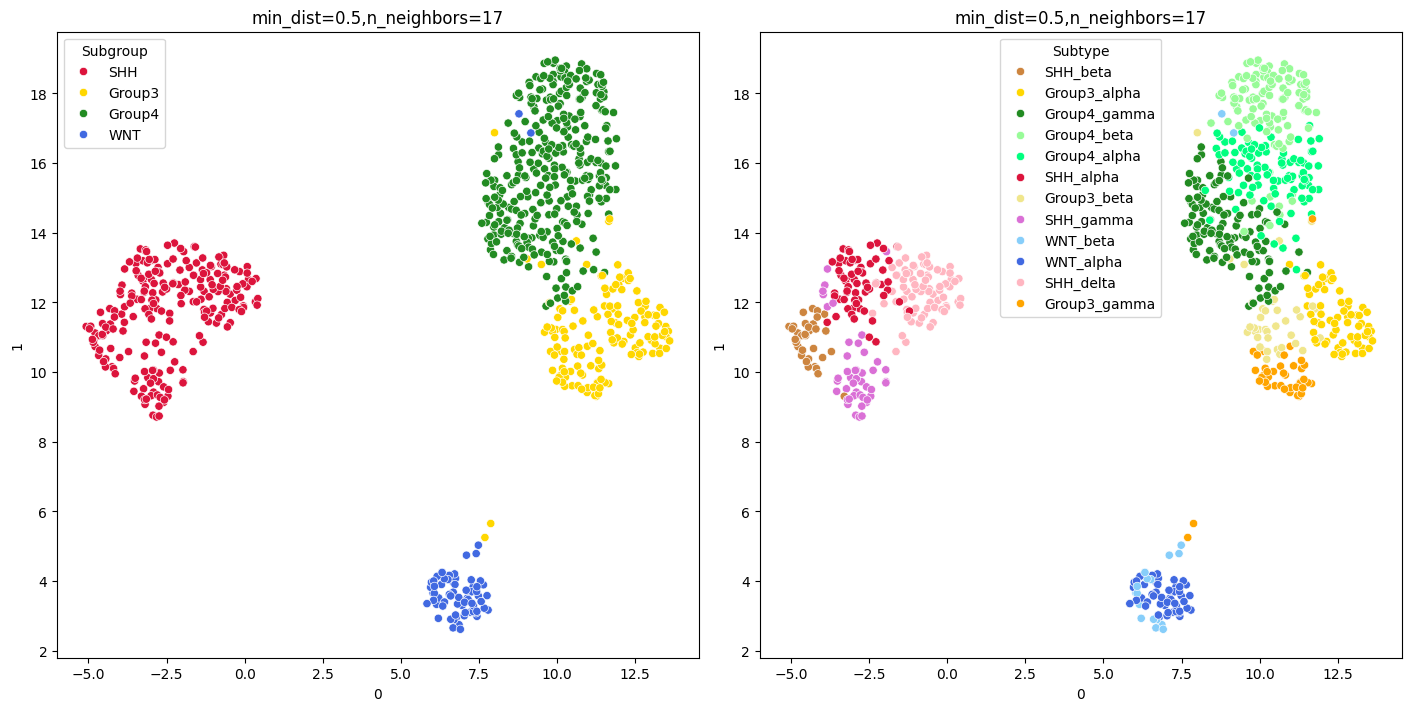

In [103]:

mat = both_umap(exp_mat=data.exp_mat.T,metadata=data.meta,parms={'min_dist': 0.5, 'n_neighbors': 17})
